In [1]:
import arff, tqdm, math
import pandas as pd
import statsmodels.api as sm
import warnings
from scipy.stats import linregress  
import matplotlib.pyplot as plt
warnings.filterwarnings('once')

In [2]:
train_data_path = 'data/French_Motor_Claims_Datasets_train.csv'
test_data_path = 'data/French_Motor_Claims_Datasets_test.csv'

In [3]:
def explode_categorical_cols(data, col_name):
    for v in data[col_name].unique():
        data[v] = (data[col_name] == v).astype(int)
    return data

In [4]:
def display_plt(x: pd.Series, y: pd.Series, model, x_pred: pd.DataFrame):
    plt.scatter(x, y, s=2)
    ypred = model.predict(sm.add_constant(x_pred)) 
    plt.ylim((0, ypred.max() * 10))
    plt.plot(x, ypred, color='r')
    
def display_model_plt(data, models, iv):
    _data = data.sort_values(iv)
    display_plt(_data[iv], _data['ClaimAmount_per_year'], models[models.IV == iv].iloc[0].model, _data[[iv]])


In [5]:
def display_axs_plt(x: pd.Series, y: pd.Series, model, x_pred: pd.DataFrame, axs, iv):
    axs.scatter(x, y, s=2)
    ypred = model.predict(sm.add_constant(x_pred)) 
    axs.set_ylim(ymin=0, ymax=ypred.max() * 10)
    axs.set_title(iv)
    axs.plot(x, ypred, color='r')
    
def subplot_display_sqaured_model_plt(data, models, iv, axs):
    _data = data.sort_values(iv)
    display_axs_plt(_data[iv], _data['ClaimAmount_per_year'], models[models.IV == iv].iloc[0].model, polynomial_ivs(_data[iv], 2), axs, iv)

## Preparations

In [6]:
# Read data
data_freq = arff.load('data/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('data/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [7]:
# Check completeness
assert df_freq[df_freq.isna().any(axis=1)].shape[0] == 0
assert df_sev[df_sev.isna().any(axis=1)].shape[0] == 0

In [8]:
# Calculate claim amount per year
df_sev = df_sev.groupby('IDpol').sum().reset_index()
data = df_freq.merge(df_sev, on='IDpol', how='left')
data['ClaimAmount'] = data['ClaimAmount'].fillna(0)
data['ClaimAmount_per_year'] = data['ClaimAmount'] / data['Exposure']

In [9]:
# Readable labels
data['Area'] = data['Area'].apply(lambda x: 'Area_%s' % x.replace("'", ''))
data['VehGas'] = data['VehGas'].apply(lambda x: 'VehGas_%s' % x.replace("'", ''))
data['VehBrand'] = data['VehBrand'].apply(lambda x: 'VehBrand_%s' % x.replace("'", ''))
data['Region'] = data['Region'].apply(lambda x: 'Region_%s' % x.replace("'", ''))

In [10]:
data = explode_categorical_cols(data, 'Area')
data = explode_categorical_cols(data, 'VehGas')
data = explode_categorical_cols(data, 'VehBrand')
data = explode_categorical_cols(data, 'Region')

In [11]:
data = data.drop(columns=['ClaimAmount', 'Exposure', 'ClaimNb', 'Area', 'VehGas', 'VehBrand', 'Region'])

In [12]:
train_data = data.sample(int(data.shape[0] * 0.8))
test_data = data[~data.IDpol.isin(train_data.IDpol)]

In [13]:
train_data.to_csv(train_data_path, index=False)
test_data.to_csv(test_data_path, index=False)

In [6]:
# Start here for exact reproducibility
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [7]:
train_data

,IDpol,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount_per_year,Area_D,Area_B,Area_E,...,Region_R26,Region_R53,Region_R73,Region_R42,Region_R25,Region_R21,Region_R41,Region_R43,Region_R74,Region_R23
0,1008353.0,7.0,1.0,78.0,54.0,5332.0,0.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2219121.0,6.0,12.0,28.0,80.0,6736.0,0.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,153181.0,6.0,11.0,62.0,68.0,16.0,1128.12,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3241417.0,6.0,6.0,62.0,72.0,3317.0,0.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4124835.0,9.0,15.0,38.0,54.0,289.0,0.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542405,5068514.0,10.0,9.0,50.0,50.0,614.0,0.00,1,0,0,...,0,0,0,0,0,0,0,0,0,0
542406,6110226.0,10.0,5.0,44.0,50.0,626.0,0.00,1,0,0,...,0,0,0,0,0,0,0,0,0,0
542407,1022441.0,7.0,4.0,71.0,50.0,121.0,0.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
542408,2147451.0,6.0,12.0,33.0,80.0,388.0,0.00,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def run_ols(data, x_columns, y_column):
    y = data[y_column]
    x = sm.add_constant(data[x_columns])
    model = sm.OLS(y, x).fit()
    return model

def get_params(model, iv):
    df = pd.concat([
        model.pvalues.to_frame().T.rename(columns={'const': 'p_const', iv: 'p_IV1'}), 
        model.params.to_frame().T.rename(columns={iv: 'koef_IV1'})], axis=1)
    df['rsquared_adj'] = model.rsquared_adj
    df['model'] = model
    return df

def calculate_r2_adj(y_true, y_pred, count_ivs):
    """
    Formula from https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
    """
    slope, intercept, r_value, p_value, std_err = linregress(y_pred, y_true)
    r2 = r_value ** 2
    r2_adj = 1-(1-r2)*((y_true.shape[0]-1)/(y_true.shape[0]-count_ivs-1))
    return r2_adj

In [9]:
summary_data = []

In [10]:
ivs = [c for c in train_data.columns if c not in ['IDpol', 'ClaimAmount_per_year']]

## First approach: lines

In [11]:
# Calculate separate models for each IV
results = []
for iv in tqdm.tqdm(ivs):
    model = run_ols(train_data, [iv], 'ClaimAmount_per_year')
    params = get_params(model, iv)
    params['IV'] = iv
    results.append(params)
    
df_models_linear = pd.concat(results)

100%|██████████| 46/46 [00:02<00:00, 15.68it/s]


In [12]:
df_models_filtered = df_models_linear[df_models_linear.p_IV1 < 0.05]

In [13]:
# Calculate weights
# w_i = log(p_IV_i, 10)
df_models_filtered['weight'] = -df_models_filtered['p_IV1'].apply(lambda x: math.log(x, 10))
df_models_filtered['weight'] = df_models_filtered['weight'] / df_models_filtered['weight'].sum()

/var/folders/zx/pc6s5ctj12n7vjr7t_x868sw0000gp/T/ipykernel_10941/2156643648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_models_filtered['weight'] = -df_models_filtered['p_IV1'].apply(lambda x: math.log(x, 10))


In [14]:
df_models_filtered.sort_values('p_IV1')

,p_const,p_IV1,const,koef_IV1,rsquared_adj,model,IV,weight
0,2.146280e-06,8.182762e-12,-1033.740204,24.132896,0.000084,<statsmodels.regression.linear_model.Regressio...,BonusMalus,0.582190
0,9.044302e-11,7.180167e-06,1206.343737,-17.533844,0.000035,<statsmodels.regression.linear_model.Regressio...,DrivAge,0.270107
0,8.194212e-07,1.538805e-03,311.492679,411.915462,0.000017,<statsmodels.regression.linear_model.Regressio...,VehBrand_B2,0.147703


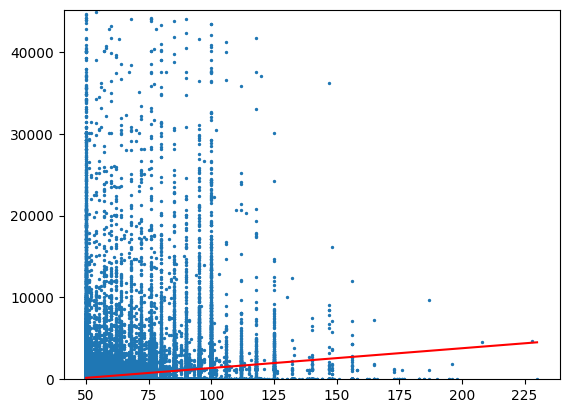

In [15]:
display_model_plt(train_data, df_models_filtered, 'BonusMalus')

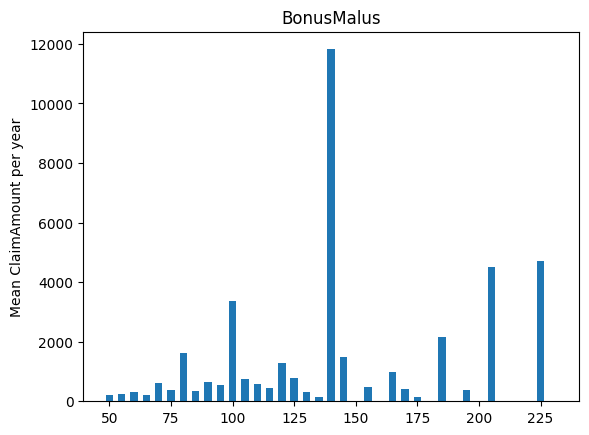

In [16]:
chart_data = train_data.copy()
chart_data['BonusMalus'] = (chart_data['BonusMalus'] / 5).astype(int) * 5
grouped = chart_data[['BonusMalus','ClaimAmount_per_year']].groupby('BonusMalus').mean().reset_index().sort_values('BonusMalus')
y_pos = grouped.BonusMalus
x_pos = grouped.ClaimAmount_per_year

plt.bar(y_pos, x_pos, width=3)
plt.ylabel('Mean ClaimAmount per year')
plt.title('BonusMalus')
plt.show()

In [17]:
_test_data= test_data.copy()

In [18]:
# Calculate predictions
# 1) for each filtered model
# 2) as linear combination of filtered models 
#    Y = sum_over_i(w_i * (beta_0_i + beta_1_i * X_1_i)) 
model_predictions = []
r2_adj_models = {}
y_true = _test_data.ClaimAmount_per_year
for i, r in df_models_filtered.iterrows():
    y_pred = r['model'].predict(sm.add_constant(_test_data[[r['IV']]]))
    model_predictions.append(y_pred * r['weight'])
    r2_adj_models[r['IV']] = calculate_r2_adj(y_true, y_pred, 1)
combined = pd.concat(model_predictions, axis=1).sum(axis=1)  
_test_data['weighted_prediction'] = combined 

In [19]:
for k in r2_adj_models.keys():
    summary_data.append({'IVs': [k], 
                         'r2_adj': r2_adj_models[k],
                         'custom_weights': False})
    print(k, r2_adj_models[k])

DrivAge 3.532541697026659e-05
BonusMalus 0.0001024445572931354
VehBrand_B2 -7.331212374284135e-06


In [20]:
 # R2 for predictions on combined y_pred
y_pred = _test_data.weighted_prediction
count_ivs = df_models_filtered.shape[0]
r2_adj_linear_weights = calculate_r2_adj(y_true, y_pred, count_ivs)
summary_data.append({'IVs': sorted(df_models_filtered.IV), 
                     'r2_adj': r2_adj_linear_weights,
                     'custom_weights': True})
r2_adj_linear_weights

np.float64(8.87544896842618e-05)

In [21]:
# Calculate predictions and R2_adj for filtered IV in one model
model = run_ols(train_data, df_models_filtered.IV, 'ClaimAmount_per_year')
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     ClaimAmount_per_year   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     19.65
Date:                  Sat, 14 Dec 2024   Prob (F-statistic):           9.91e-13
Time:                          15:49:13   Log-Likelihood:            -6.5263e+06
No. Observations:                542410   AIC:                         1.305e+07
Df Residuals:                    542406   BIC:                         1.305e+07
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -671.4825    386.

In [22]:
model = run_ols(train_data, df_models_filtered.IV, 'ClaimAmount_per_year')
y_pred = model.predict(sm.add_constant(test_data[df_models_filtered.IV]))
count_ivs = df_models_filtered.shape[0]
r2_adj_linear = calculate_r2_adj(y_true, y_pred, count_ivs)
summary_data.append({'IVs': sorted(df_models_filtered.IV), 
                     'r2_adj': r2_adj_linear,
                     'custom_weights': False})
r2_adj_linear

np.float64(6.953289876177049e-05)

## 2nd approach: models with quadratic term

In [23]:
def polynomial_ivs(x: pd.Series, degree: int):
    name = x.name
    df = x.to_frame()
    for i in range(2, degree + 1):
        df[f'{name}**{i}'] = df[name] ** degree
    return df

def get_params_squared_model(model, ivs):
    df = pd.concat([
        model.pvalues.to_frame().T.rename(columns={'const': 'p_const', ivs[0]: 'p_IV1', ivs[1]: 'p_IV1**2'}), 
        model.params.to_frame().T.rename(columns={ivs[0]: 'koef_IV1', ivs[1]: 'koef_IV**2'})], axis=1)
    df['rsquared_adj'] = model.rsquared_adj
    df['model'] = model
    return df

In [24]:
# Calculate separate models for each IV with IV**2
results = []
for iv in tqdm.tqdm(ivs):
    model_data = pd.concat([train_data['ClaimAmount_per_year'], polynomial_ivs(train_data[iv], 2)], axis=1)
    model_ivs = [x for x in model_data.columns if x != 'ClaimAmount_per_year']
    model = run_ols(model_data, model_ivs, 'ClaimAmount_per_year')
    params = get_params_squared_model(model, model_ivs)
    params['IV'] = iv
    results.append(params)
    
df_models = pd.concat(results)

100%|██████████| 46/46 [00:05<00:00,  8.76it/s]


In [25]:
df_models.sort_values('p_IV1**2')

,p_const,p_IV1,p_IV1**2,const,koef_IV1,koef_IV**2,rsquared_adj,model,IV
0,1.798305e-14,1.275201e-10,9.558182e-09,4021.689999,-1.447720e+02,1.310072e+00,9.415685e-05,<statsmodels.regression.linear_model.Regressio...,DrivAge
0,7.030621e-09,6.877633e-02,6.877633e-02,358.044026,1.250326e+02,1.250326e+02,4.262447e-06,<statsmodels.regression.linear_model.Regressio...,Area_E
0,3.617506e-13,8.702070e-02,8.702070e-02,402.323010,7.049241e+02,7.049241e+02,3.555702e-06,<statsmodels.regression.linear_model.Regressio...,Region_R21
0,8.996166e-10,2.314302e-01,2.314302e-01,473.358973,-6.609658e+01,-6.609658e+01,7.965446e-07,<statsmodels.regression.linear_model.Regressio...,VehGas_Diesel
0,1.550734e-05,2.314302e-01,2.314302e-01,341.165803,6.609658e+01,6.609658e+01,7.965446e-07,<statsmodels.regression.linear_model.Regressio...,VehGas_Regular
0,2.595982e-11,2.846569e-01,2.846569e-01,388.701601,9.732525e+01,9.732525e+01,2.668163e-07,<statsmodels.regression.linear_model.Regressio...,Region_R11
0,8.550393e-01,9.481322e-01,3.150792e-01,-163.240792,-1.687665e+00,1.762601e-01,8.430711e-05,<statsmodels.regression.linear_model.Regressio...,BonusMalus
0,6.517073e-13,3.324364e-01,3.324364e-01,431.466808,-7.426007e+01,-7.426007e+01,-1.117513e-07,<statsmodels.regression.linear_model.Regressio...,Area_A
0,2.880492e-11,3.325927e-01,3.325927e-01,389.732741,8.499426e+01,8.499426e+01,-1.128703e-07,<statsmodels.regression.linear_model.Regressio...,Area_B
0,2.997396e-08,3.909518e-01,3.606954e-01,378.928341,3.142841e-02,-1.407977e-06,-2.144866e-06,<statsmodels.regression.linear_model.Regressio...,Density


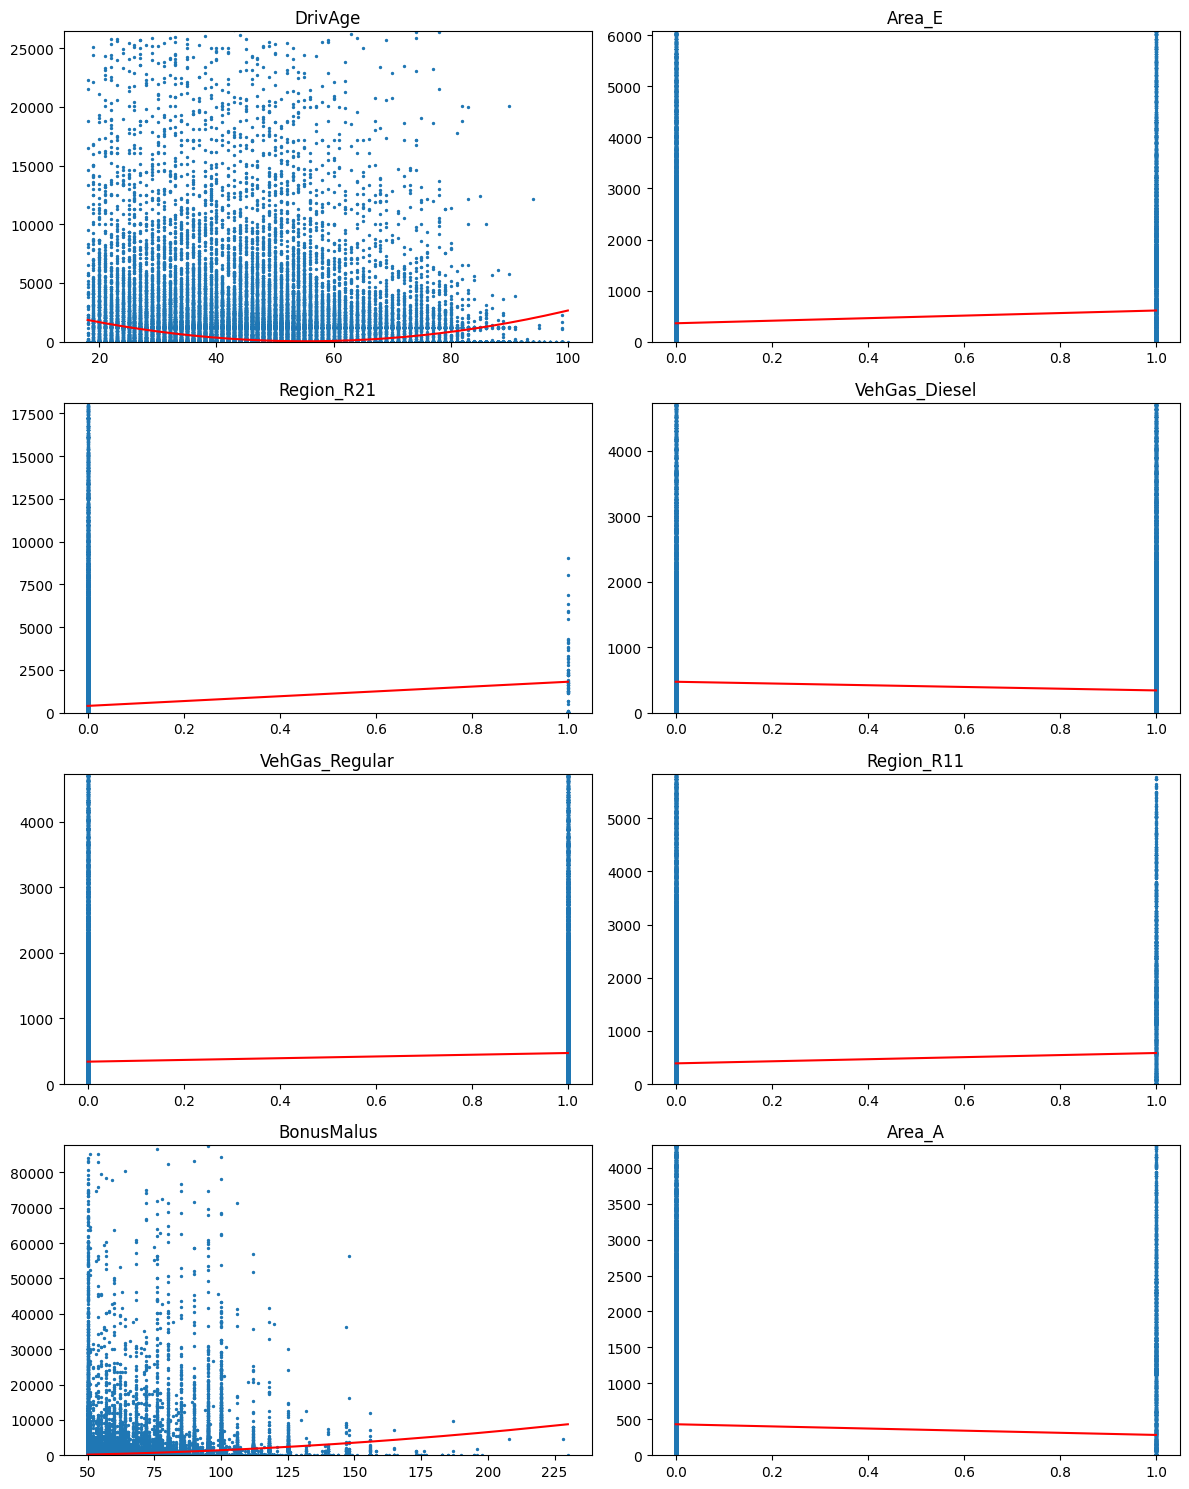

In [26]:
fig, axs = plt.subplots(4, 2)
subplot_display_sqaured_model_plt(train_data, df_models, 'DrivAge', axs[0, 0])
subplot_display_sqaured_model_plt(train_data, df_models, 'Area_E', axs[0, 1])
subplot_display_sqaured_model_plt(train_data, df_models, 'Region_R21', axs[1, 0])
subplot_display_sqaured_model_plt(train_data, df_models, 'VehGas_Diesel', axs[1, 1])
subplot_display_sqaured_model_plt(train_data, df_models, 'VehGas_Regular', axs[2, 0])
subplot_display_sqaured_model_plt(train_data, df_models, 'Region_R11', axs[2, 1])
subplot_display_sqaured_model_plt(train_data, df_models, 'BonusMalus', axs[3, 0])
subplot_display_sqaured_model_plt(train_data, df_models, 'Area_A', axs[3, 1])
fig.set_figwidth(12)
fig.set_figheight(15)
fig.tight_layout()

* DrivAge looks good
* quadratic terms make no sense for boolean variables
* BonusMalus performs worse with quadratic term than linear

In [27]:
# Calculate predictions and R2_adj for DrivAge
input_data = polynomial_ivs(test_data['DrivAge'], 2)
y_pred = df_models[df_models.IV == 'DrivAge'].iloc[0].model.predict(sm.add_constant(sm.add_constant(input_data))) 
y_true = test_data.ClaimAmount_per_year
count_ivs = 2
r2_adj_driv_age = calculate_r2_adj(y_true, y_pred, count_ivs)
summary_data.append({'IVs': sorted(input_data.columns), 
                     'r2_adj': r2_adj_driv_age,
                     'custom_weights': False})
r2_adj_driv_age

np.float64(8.181672018936492e-05)

## 3rd approach: DrivAge quadratic, rest linear

In [28]:
_train_data = train_data.copy()
_train_data['DrivAge**2'] = _train_data['DrivAge'] ** 2

In [29]:
# Start with better 23 of 46 IVs
selected_ivs = list(df_models_linear.sort_values('p_IV1')[:23].IV)
selected_ivs += ['DrivAge**2']

In [30]:
model = run_ols(_train_data, selected_ivs, 'ClaimAmount_per_year')

In [31]:
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     ClaimAmount_per_year   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     3.849
Date:                  Sat, 14 Dec 2024   Prob (F-statistic):           1.25e-09
Time:                          15:49:28   Log-Likelihood:            -6.5263e+06
No. Observations:                542410   AIC:                         1.305e+07
Df Residuals:                    542386   BIC:                         1.305e+07
Df Model:                            23                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1235.699

In [32]:
_test_data = test_data.copy()
_test_data['DrivAge**2'] = _test_data['DrivAge'] ** 2

In [33]:
y_pred = model.predict(sm.add_constant(sm.add_constant(_test_data[selected_ivs]))) 

In [34]:
y_true = _test_data['ClaimAmount_per_year']
r2_adj_selected_ivs = calculate_r2_adj(y_true, y_pred, len(selected_ivs))
summary_data.append({'IVs': sorted(_test_data[selected_ivs].columns), 
                     'r2_adj': r2_adj_selected_ivs,
                     'custom_weights': False})
r2_adj_selected_ivs

np.float64(-0.00011265958123818365)

In [35]:
# Remove not efficient IVs
model_p_values = model.pvalues.to_frame().drop('const')
selected_ivs_filtered = list(model_p_values[model_p_values[0] < 0.05].index)

In [36]:
model2 = run_ols(_train_data, selected_ivs_filtered, 'ClaimAmount_per_year')

In [37]:
print(model2.summary())

                             OLS Regression Results                             
Dep. Variable:     ClaimAmount_per_year   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     14.89
Date:                  Sat, 14 Dec 2024   Prob (F-statistic):           1.20e-14
Time:                          15:49:29   Log-Likelihood:            -6.5263e+06
No. Observations:                542410   AIC:                         1.305e+07
Df Residuals:                    542404   BIC:                         1.305e+07
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1262.697

In [38]:
y_pred2 = model2.predict(sm.add_constant(sm.add_constant(_test_data[selected_ivs_filtered]))) 

In [39]:
r2_adj_selected_ivs_filtered = calculate_r2_adj(y_true, y_pred2, len(selected_ivs_filtered))
summary_data.append({'IVs': sorted(_test_data[selected_ivs_filtered].columns), 
                     'r2_adj': r2_adj_selected_ivs_filtered,
                     'custom_weights': False})
r2_adj_selected_ivs_filtered

np.float64(5.243348612493648e-05)

In [40]:
# Remove not efficient IVs with lower significance level
model2_p_values = model2.pvalues.to_frame().drop('const')
selected_ivs_filtered_filtered = list(model2_p_values[model2_p_values[0] < 0.005].index)

In [41]:
model3 = run_ols(_train_data, selected_ivs_filtered_filtered, 'ClaimAmount_per_year')

In [42]:
print(model3.summary())

                             OLS Regression Results                             
Dep. Variable:     ClaimAmount_per_year   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     18.36
Date:                  Sat, 14 Dec 2024   Prob (F-statistic):           4.23e-15
Time:                          15:49:29   Log-Likelihood:            -6.5263e+06
No. Observations:                542410   AIC:                         1.305e+07
Df Residuals:                    542405   BIC:                         1.305e+07
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1907.5515    779.

In [43]:
y_pred3 = model3.predict(sm.add_constant(sm.add_constant(_test_data[selected_ivs_filtered_filtered]))) 

In [44]:
r2_adj_selected_ivs_filtered_filtered = calculate_r2_adj(y_true, y_pred3, len(selected_ivs_filtered_filtered))
summary_data.append({'IVs': sorted(_test_data[selected_ivs_filtered_filtered].columns), 
                     'r2_adj': r2_adj_selected_ivs_filtered_filtered,
                     'custom_weights': False})
r2_adj_selected_ivs_filtered_filtered

np.float64(8.215840340974889e-05)

In [45]:
print('Summary of created models tested on test data ordered by best to worse')
pd.DataFrame({'r2_adj': [e['r2_adj'] for e in summary_data], 
              'IVs': [e['IVs'] for e in summary_data], 
              'custom_weights': [e['custom_weights'] for e in summary_data]}).sort_values('r2_adj', ascending=False)

Summary of created models tested on test data ordered by best to worse


,r2_adj,IVs,custom_weights
1,0.000102,[BonusMalus],False
3,0.000089,"[BonusMalus, DrivAge, VehBrand_B2]",True
8,0.000082,"[BonusMalus, DrivAge, DrivAge**2, VehBrand_B2]",False
5,0.000082,"[DrivAge, DrivAge**2]",False
4,0.000070,"[BonusMalus, DrivAge, VehBrand_B2]",False
7,0.000052,"[BonusMalus, DrivAge, DrivAge**2, VehBrand_B2,...",False
0,0.000035,[DrivAge],False
2,-0.000007,[VehBrand_B2],False
6,-0.000113,"[Area_A, Area_B, Area_C, Area_E, BonusMalus, D...",False


## Further steps:
* Polynomials with higher degrees
* Dependencies between independent variables, products of independent variables
* Logarithmic terms
* Use other algorithms for linear regression than OLS (Ordinary least squares), e.g. GLM (Generalized linear model)
* Parameterization in an automatic process with subsequent evaluation to determine the optimal version
* Nonlinear regression